# Results
The **Result** class the outcome of an **Experiment**. It has several features to support easy analysis. In this notebook we will learn:
1. **Result Creation**: How to create a Result from an Experiment.
2. **Result Plotting**: How to create plots of the learners that were evaluted by an experiment
3. **Result Loading**: How to load results from disk
4. **Result Filtering**: How to use filtering to create custom plots from a large experiment result 
5. **Result to Pandas**: How to turn Result into a collection of Pandas dataframes for more in-depth analysis

## Result Creation

**Results** are created whenever an experiment is evaluated. Below is a simple example of this:

In [3]:
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalLearner
from coba.experiments  import Experiment

environments = Environments.from_linear_synthetic().shuffle([1,2,3])
learners     = [RandomLearner(), VowpalLearner()]
results      = Experiment(environments,learners).evaluate()

2021-12-14 16:39:38 Processing chunk...
2021-12-14 16:39:38   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2021-12-14 16:39:38   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2021-12-14 16:39:38   * Loading LinearSynth(A=3,c=2,a=2,X=['a', 'xa'],seed=1)... (0.0 seconds) (completed)
2021-12-14 16:39:38   * Creating Environment 0 from Loaded Source... (0.01 seconds) (completed)
2021-12-14 16:39:38   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2021-12-14 16:39:38   * Evaluating Learner 0 on Environment 0... (0.03 seconds) (completed)
2021-12-14 16:39:40   * Evaluating Learner 1 on Environment 0... (1.35 seconds) (completed)
2021-12-14 16:39:40   * Creating Environment 1 from Loaded Source... (0.0 seconds) (completed)
2021-12-14 16:39:40   * Recording Environment 1 statistics... (0.0 seconds) (completed)
2021-12-14 16:39:40   * Evaluating Learner 0 on Environment 1... (0.03 seconds) (completed)
2021-12-14 16:39:41   * Evaluating Learner

## Result Plotting

With a **Result** class one can plot the performance of learners. This is a great way to quickly get a sense of the experiment. 

Below we plot the result of our experiment above.

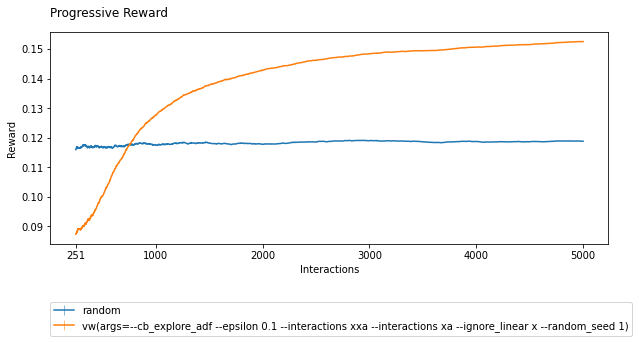

In [2]:
result.plot_learners()

The `plot_learners` method has many arguments which allow customization of the plot.
```
Args:
    xlim: Define the x-axis limits to plot. If `None` the x-axis limits will be inferred.
    ylim: Define the y-axis limits to plot. If `None` the y-axis limits will be inferred.
    span: In general this indicates how many previous evaluations to average together. In practice this works
        identically to ewm span value in the Pandas API. Additionally, if span equals None then all previous 
        rewards are averaged together vs span = 1 WHERE the instantaneous reward is plotted for each interaction.
    err: Determine what kind of error bars to plot (if any). Valid types are `None`, 'se', and 'sd'. If `None`
        then no bars are plotted, if 'se' the standard error is shown, and if 'sd' the standard deviation is shown.
    each: Determine whether each individual environment used to estimate mean performance is also plotted.
    ax: Provide an optional axes that the plot will be drawn to. If not provided a new figure/axes is created.
```

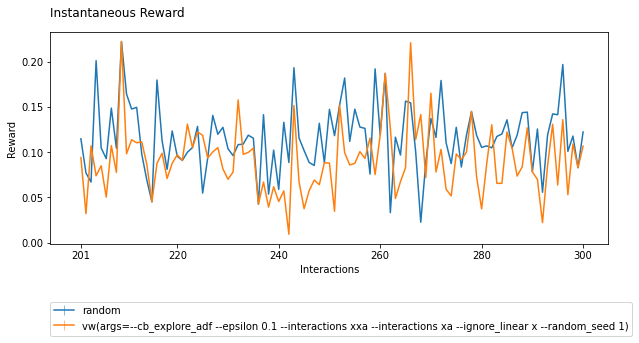

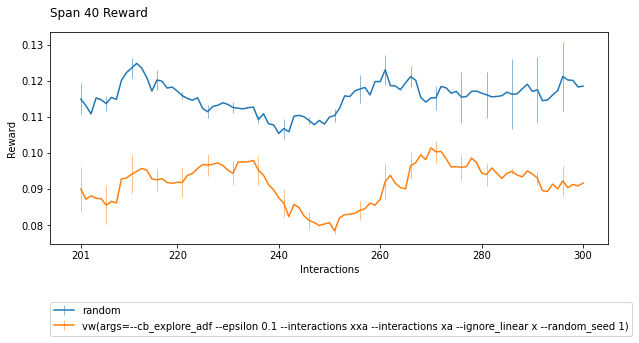

In [10]:
result.plot_learners(xlim=(200,300), span=1 , err=None)
result.plot_learners(xlim=(200,300), span=40, err='se')

## Result Loading

Results can also loaded from an Experiment restoration file.

2021-11-18 13:10:30 Processing chunk...
2021-11-18 13:10:30   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2021-11-18 13:10:30   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2021-11-18 13:10:30   * Loading source DebugSimulation(A=3,c=2,a=2,seed=1)... (0.0 seconds) (completed)
2021-11-18 13:10:30   * Creating Environment 0 from DebugSimulation(A=3,c=2,a=2,seed=1)... (0.0 seconds) (completed)
2021-11-18 13:10:30   * Calculating Environment 0 statistics... (0.0 seconds) (completed)
2021-11-18 13:10:30   * Evaluating Learner 0 on Environment 0... (0.06 seconds) (completed)
2021-11-18 13:10:31   * Evaluating Learner 1 on Environment 0... (1.42 seconds) (completed)
2021-11-18 13:10:31   * Creating Environment 1 from DebugSimulation(A=3,c=2,a=2,seed=1)... (0.01 seconds) (completed)
2021-11-18 13:10:31   * Calculating Environment 1 statistics... (0.01 seconds) (completed)
2021-11-18 13:10:31   * Evaluating Learner 0 on Environment 1... (0.07 seconds) (complet

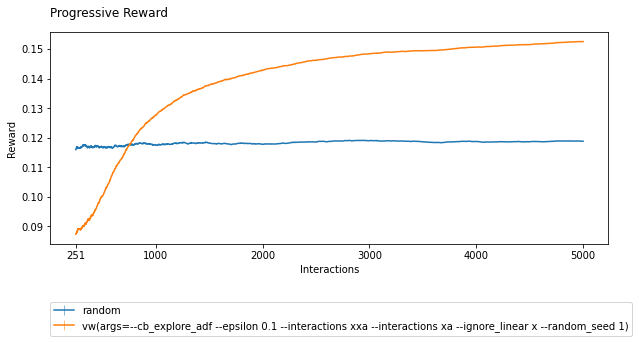

In [14]:
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalLearner
from coba.experiments  import Experiment, Result

Experiment(Environments.from_debug().shuffle([1,2,3]),[RandomLearner(), VowpalLearner(epsilon=0.1)]).evaluate('results.log')

Result.from_file('results.log').plot_learners()

## Result Filtering

Often times we only want to plot certain learners or environments. Below are two examples of when and how this can be done.

### Filtering to Finished Environments

One particularly useful feature is looking at the results of an experiment while it runs (this can be done by loading an Experiment restoration file at any time while the experiment is running). When doing this it is useful to filter the results down to just the Environments that have been fully processed. Otherwise some learners may look better or worse simply because they have been evaluated against a particularly easy/hard environment. Filtering to just finished environments looks like this.

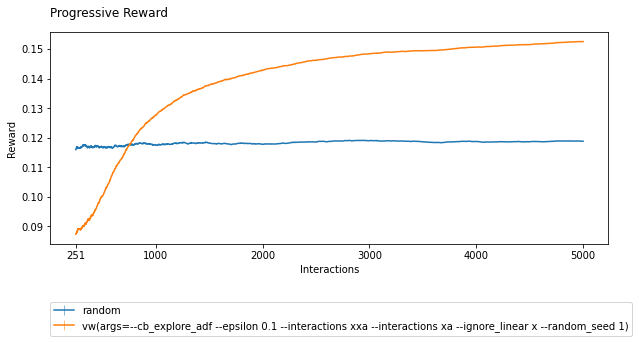

In [15]:
Result.from_file('results.log').filter_fin().plot_learners()

### Filtering In General

When running very large experiments it can often be useful to filter down to specific learners or environments. This can be done using the filter_lrn and filter_sim methods. Below is an example where we filter down to just the vw learner. When using strings it will perform a regex match so this can be very powerful.

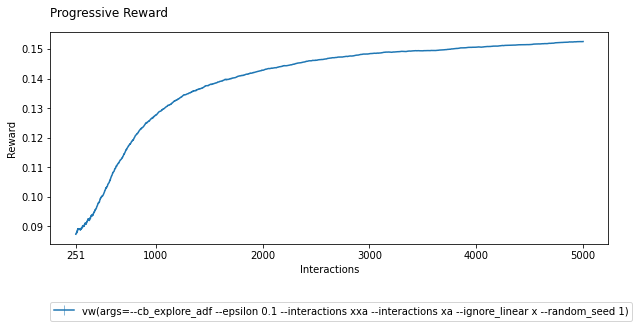

In [16]:
Result.from_file('results.log').filter_lrn(full_name='vw').plot_learners()

## Result to Pandas

Finally, often times the analysis that we wish to do simply isn't possible with the built in Result methods. In this case we can turn the various pieces of Result into panda dataframes. There are three items within Result which can be turned into dataframes. Below we show all three:

In [22]:
result = Result.from_file('results.log')
result.learners.to_pandas()

,learner_id,family,full_name,args
0,0,random,random,None
1,1,vw,vw(args=--cb_explore_adf --epsilon 0.1 --inter...,--cb_explore_adf --epsilon 0.1 --interactions ...


In [21]:
result = Result.from_file('results.log')
result.environments.to_pandas()

,environment_id,source,shuffle
0,0,DebugSimulation,1
1,1,DebugSimulation,2
2,2,DebugSimulation,3


In [20]:
result = Result.from_file('results.log')
result.interactions.to_pandas()

,environment_id,learner_id,index,reward
0,0,0,1,0.043046
1,0,0,2,0.147880
2,0,0,3,0.045179
3,0,0,4,0.000000
4,0,0,5,0.164890
...,...,...,...,...
29995,2,1,4996,0.138970
29996,2,1,4997,0.092979
29997,2,1,4998,0.118170
29998,2,1,4999,0.203720
